# Scatter Plot Visualization Data

Lets Try:

- Put all the LOI's on a single 2D plot
- Each point represents an LOI document
- The coordinates of the point are from some sort of clustering
- The color of the point is the area it was submitted to
- Mouse over gets you some "intersting" metadata:
   - The filename
   - The first 100 characters of text
   - An active link to the PDF

In order to do this we need to generate a bunch of data and write it out in a CSV file.

## Config

In [1]:
n_components = 2
n_word_summary = 100

## Setup

In [2]:
from config import text_file_info, word_vectors

# from collections import defaultdict
from pathlib import Path
import json

from sklearn.decomposition import PCA

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Files

In [3]:
file_by_area = list(text_file_info())

In [4]:
data_filenames = [f[2] for f in file_by_area]
file_names = [f[0] for f in file_by_area]
file_areas = [f[1] for f in file_by_area]

## Text

We want the first n words of text from each file. Grab them here.

In [5]:
file_text_summary = [' '.join(Path(f).read_text().split()[:n_word_summary]) for f in data_filenames]

## 2D Coordinates from Text Contents

In [6]:
%%time
x, vectorizer = word_vectors(data_filenames)

CPU times: user 2.4 s, sys: 555 ms, total: 2.95 s
Wall time: 7.65 s


Now we do the Principle Component Analysis

In [7]:
pca = PCA(n_components)

In [8]:
%%time
loi_coordinates = pca.fit_transform(x.A)

CPU times: user 1.59 s, sys: 1.41 s, total: 3 s
Wall time: 464 ms


Round them so we don't send too much data.

In [9]:
loi_coordinates = np.round(loi_coordinates, decimals=4)

Lets use `seaborn` to make a plot of this.

In [10]:
document_data = [
    {
        'x': x,
        'y': y,
        'name': str(name),
        'area': str(area),
        'url': f'https://www.snowmass21.org/docs/files/summaries/{area}/{name}.pdf',
        'summary': str(summary),
        'index': index
    }
    for index, ((x, y), name, area, summary) in enumerate(zip(loi_coordinates, file_names, file_areas, file_text_summary))
]
document_df = pd.DataFrame(document_data)

In [11]:
document_df

,x,y,name,area,url,summary,index
0,-0.0719,0.0051,SNOWMASS21-AF-TOPIC0-001,AF,https://www.snowmass21.org/docs/files/summarie...,"May 21, 2020 Gamma Factory L ETTER OF I NTERES...",0
1,-0.1115,-0.0571,SNOWMASS21-AF0-015,AF,https://www.snowmass21.org/docs/files/summarie...,"July 30th ,2020 2020 snowmass Letter of Intere...",1
2,-0.0327,0.0511,SNOWMASS21-AF0_AF0-091,AF,https://www.snowmass21.org/docs/files/summarie...,POTENTIAL FOR HIGH-ENERGY PHYSICS AT THE OAK R...,2
3,-0.1127,-0.1087,SNOWMASS21-AF0_AF0-215,AF,https://www.snowmass21.org/docs/files/summarie...,Plasma Processing for In-Situ Field Emission M...,3
4,-0.1360,-0.0785,SNOWMASS21-AF0_AF0-229,AF,https://www.snowmass21.org/docs/files/summarie...,Letter of Interest for Snowmass2021: R&D on Hi...,4
...,...,...,...,...,...,...,...
1561,-0.0048,-0.0135,SNOWMASS21-UF0_UF0_Garcia-Sciveres-001,UF,https://www.snowmass21.org/docs/files/summarie...,Snowmass2021 Letter of Interest: Classificatio...,1561
1562,0.0043,0.0578,SNOWMASS21-UF1_UF4-RF4_RF3_ODonnell-007,UF,https://www.snowmass21.org/docs/files/summarie...,KURF: The Kimballton Underground Research Faci...,1562
1563,0.1720,-0.0141,SNOWMASS21-UF4_UF3-NF5_NF6-CF1_CF0-IF3_IF0-Com...,UF,https://www.snowmass21.org/docs/files/summarie...,Snowmass2021 - Letter of Interest Advanced Ger...,1563
1564,0.0820,0.0155,SNOWMASS21-UF6_UF0-NF10_NF0-RF4_RF0-CF1_CF0-IF...,UF,https://www.snowmass21.org/docs/files/summarie...,Snowmass2021 - Letter of Interest Solution-min...,1564


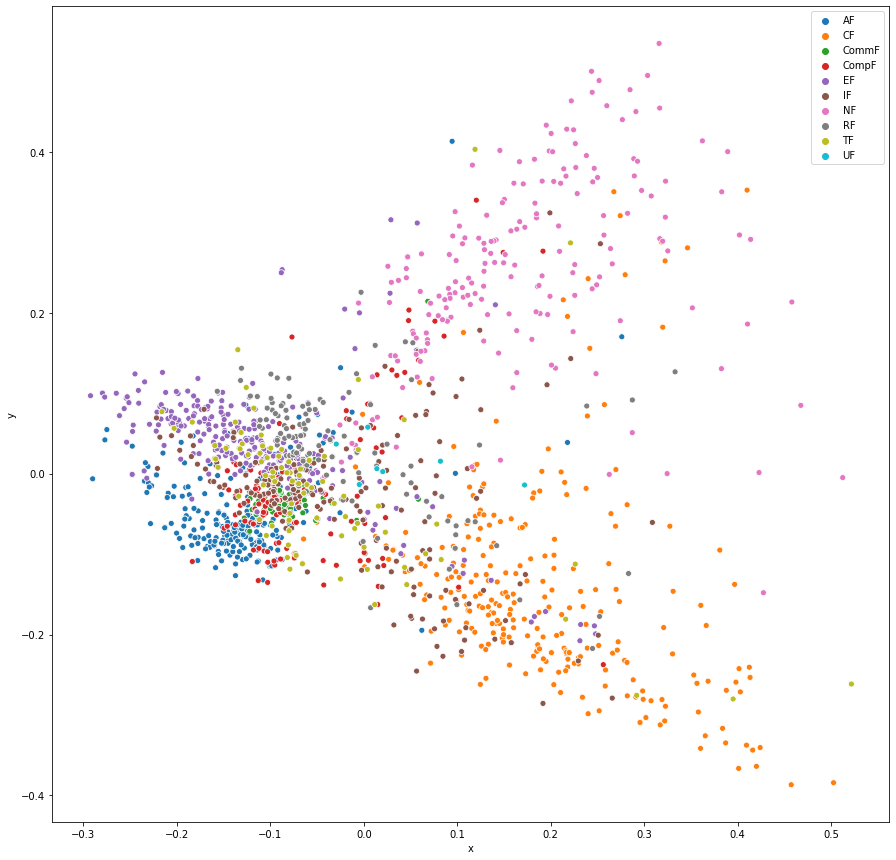

In [12]:
plt.figure(figsize=(15,15))
g = sns.scatterplot(x='x', y='y', hue=document_df.area.to_list(), data=document_df)

## Writing out the data

In [13]:
document_df.to_csv('../web/data/loi-data.csv')

## Word Frequency and Importance Data

Generate the JSON file for word importance. This allows one to identify which documents use which words, and what their relative importance is.

In [14]:
terms = vectorizer.get_feature_names()

In [15]:
%%time
term_usage_info = {}
for t_index, t in enumerate(terms):
    non_zero_index = np.nonzero(x[:,t_index])[0]
    non_zero_weight = np.take(x[:,t_index].toarray(), non_zero_index)
    non_zero_weight = np.round(non_zero_weight, decimals=4)
    doc_word_usage = {int(i): wt for i,wt in zip(non_zero_index, non_zero_weight)}
    term_usage_info[t] = doc_word_usage

CPU times: user 21.5 s, sys: 0 ns, total: 21.5 s
Wall time: 21.5 s


In [16]:
len(term_usage_info['mathusla'])

19

In [17]:
with open('../web/data/term_data.json', 'wt') as fout:
    json.dump(term_usage_info, fout)